# Analysis of Solar Cells

This example analyzes solar cells using our software.

Firstly, we import the packages required for this example.

In [1]:
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

import jaxlayerlumos as jll
import jaxlayerlumos.utils_units as jll_utils_units
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_position as jll_utils_position
import jaxlayerlumos.utils_light_sources as jll_utils_light_sources

Then, we define several constants such as light speed, Planck constant, and elementary charge.

In [2]:
c = jll_utils_units.get_light_speed()
h = jll_utils_units.get_planck_constant()
e = jll_utils_units.get_elementary_charge()
nano = jll_utils_units.get_nano()

print(f"Light speed: {c:.4e}")
print(f"Planck constant: {h:.4e}")
print(f"Elementary charge: {e:.4e}")
print(f"nano: {nano:.4e}")

Light speed: 2.9979e+08
Planck constant: 6.6261e-34
Elementary charge: 1.6022e-19
nano: 1.0000e-09


## Silicon Absorption on PEC

Crystalline silicon is the most common material for solar cells. In this example, we simulate 40 micron thick silicon on a perfect electrical conductor (PEC) and make a plot of the absorption spectra. Since crystalline silicon has a bandgap of 1.12 eV, you can see that the silicon only absorbs at photon energies greater than 1.12 eV.

In [3]:
wavelengths = jnp.linspace(280, 2000, 1000) * nano
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

materials = ["Air", "cSi", "PEC"]
thicknesses = jnp.array([0, 40000, 0]) * nano
inc_angle = 0.0

n_k = jll_utils_materials.get_n_k(materials, frequencies)
R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, inc_angle)

A = 1 - R_TE.squeeze() - T_TE.squeeze()

/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(
/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(


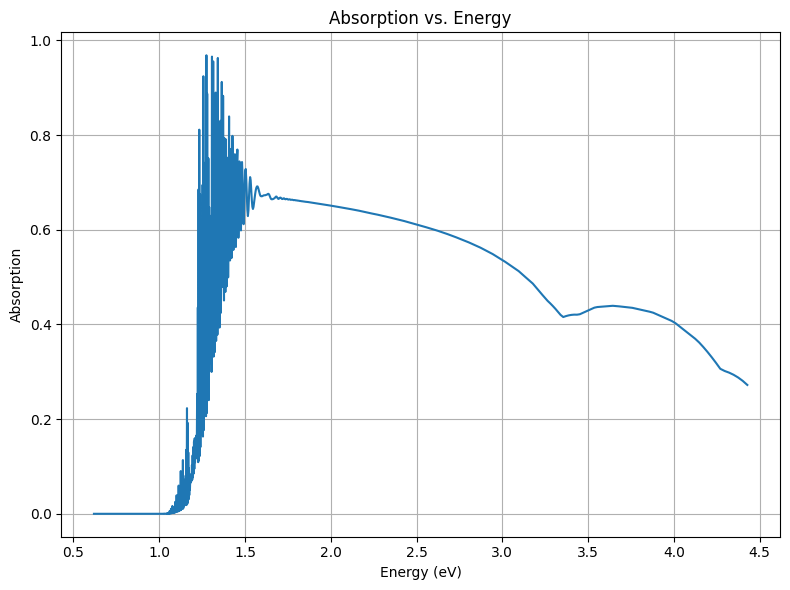

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(energy, A)

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption")
ax.set_title("Absorption vs. Energy")
ax.grid()

plt.tight_layout()
plt.show()

## Silicon Absorption on Aluminum

Here we switch the back layer to aluminum instead of a perfect electrical conductor (PEC). Since the aluminum has some parasitic absorption, we must calculate the absorption in each layer. There is a very slight difference with aluminum, but it is small so we can just use PEC. As can be seen, most of the absorption in the aluminum occurs at smaller energies and thus can be absorbed.

In [5]:
wavelengths = jnp.linspace(280, 2000, 1000) * nano
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

materials = ["Air", "cSi", "Al"]
thicknesses = jnp.array([0, 40000, 0]) * nano
material_silicon_index = 1
material_aluminum_index = 2

n_k = jll_utils_materials.get_n_k(materials, frequencies)
inc_angle = 0.0

R_TE, T_TE, R_TM, T_TM, results_coeffs = jll.stackrt(
    n_k, thicknesses, frequencies, inc_angle, return_coeffs=True
)

results_coeffs = jll_utils_position.calc_absorption_in_each_layer(
    thicknesses, results_coeffs
)

/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(


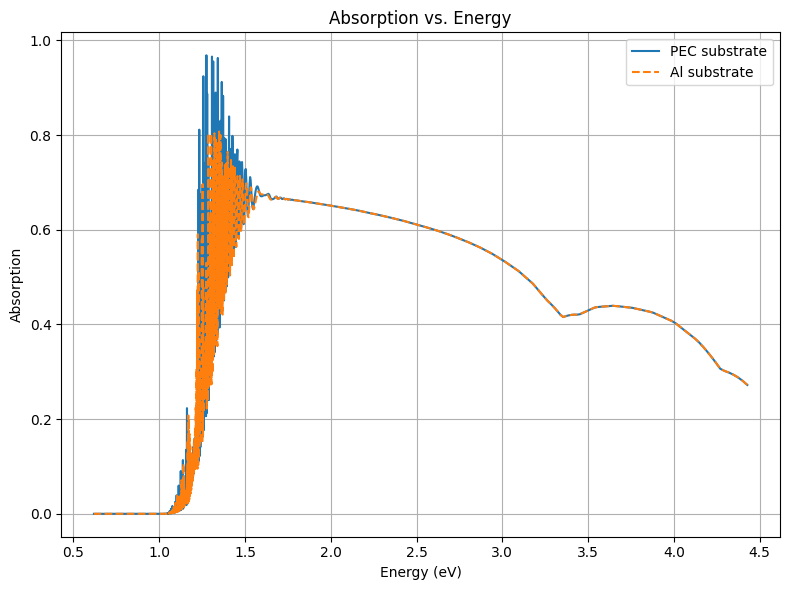

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(energy, A, label='PEC substrate')
ax.plot(energy, results_coeffs["absorption_layer_TE"][material_silicon_index, :], label='Al substrate', linestyle='dashed')

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption")
ax.set_title("Absorption vs. Energy")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()

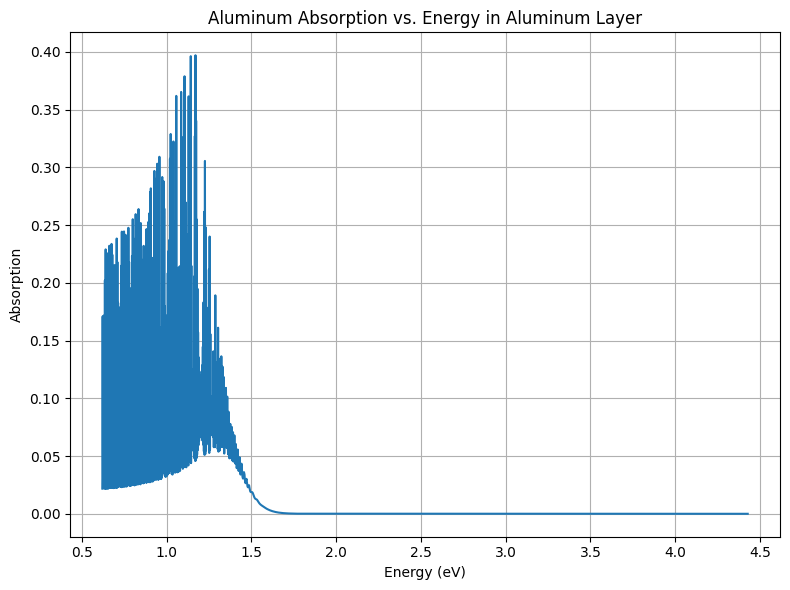

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(energy, results_coeffs["absorption_layer_TE"][material_aluminum_index, :])

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption")
ax.set_title("Aluminum Absorption vs. Energy in Aluminum Layer")
ax.grid()

plt.tight_layout()
plt.show()

## Solar Absorption

We want to calculate the solar absorption as a function of thickness.

The absorption spectra over wavelengths (or equivalently frequencies) are calculated using our package. To compute an absorption spectrum, we employ transmission and reflection spectra:
$$A = 1 - T - R,$$
where $A$ is an absorption spectrum, $T$ is a transmission spectrum, and $R$ is a reflection spectrum.

The solar absorption is defined as the fraction of photons absorbed divided by the total number of photons.

Firstly, we use the AM1.5 Global spectrum here, so the total photons of the AM1.5 Global are calculated over solar wavelengths from 280 nm to 4000 nm.

In [8]:
wavelengths_solar = jnp.linspace(280, 4000, 2000) * nano
wavelengths_solar_in_nm = jll_utils_units.convert_m_to_nm(wavelengths_solar)
irradiance_solar = jll_utils_light_sources.get_irradiance('AM1p5G', wavelengths_solar)

photon_flux_solar = (irradiance_solar * wavelengths_solar) / (h * c)
total_photons_solar = onp.trapezoid(photon_flux_solar, wavelengths_solar_in_nm)

print(f"Total photons of AM1.5 Global: {total_photons_solar:.4e}")

Total photons of AM1.5 Global: 4.3053e+21


In [9]:
wavelengths = jnp.linspace(280, 1400, 1000) * nano
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

silicon_thicknesses = jnp.linspace(100, 100000, 100) * nano
materials = ["Air", "cSi", "PEC"]
inc_angle = 0.0

n_k = jll_utils_materials.get_n_k(materials, frequencies)

irradiance = jll_utils_light_sources.get_irradiance('AM1p5G', wavelengths)
photon_flux = (irradiance * wavelengths) / (h * c)

absorption_results = []
solar_absorption_results = []

for thickness in silicon_thicknesses:
    thicknesses = jnp.array([0, thickness, 0])

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, inc_angle)
    A = 1 - R_TE - T_TE

    absorption_results.append(A)
    solar_absorption = onp.trapezoid(A * photon_flux, wavelengths / nano) / total_photons_solar
    solar_absorption_results.append(solar_absorption)

absorption_results = onp.array(absorption_results).squeeze()
solar_absorption_results = onp.array(solar_absorption_results).squeeze()

silicon_thicknesses_in_micron = jll_utils_units.convert_m_to_um(silicon_thicknesses)
X, Y = onp.meshgrid(energy, silicon_thicknesses_in_micron)

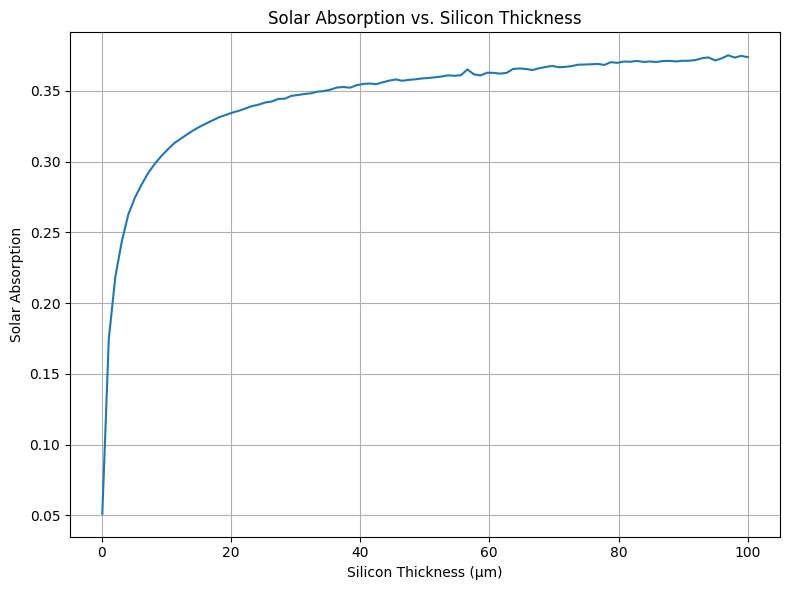

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(silicon_thicknesses_in_micron, solar_absorption_results)

ax.set_xlabel("Silicon Thickness (µm)")
ax.set_ylabel("Solar Absorption")
ax.set_title("Solar Absorption vs. Silicon Thickness")
ax.grid()

plt.tight_layout()
plt.show()

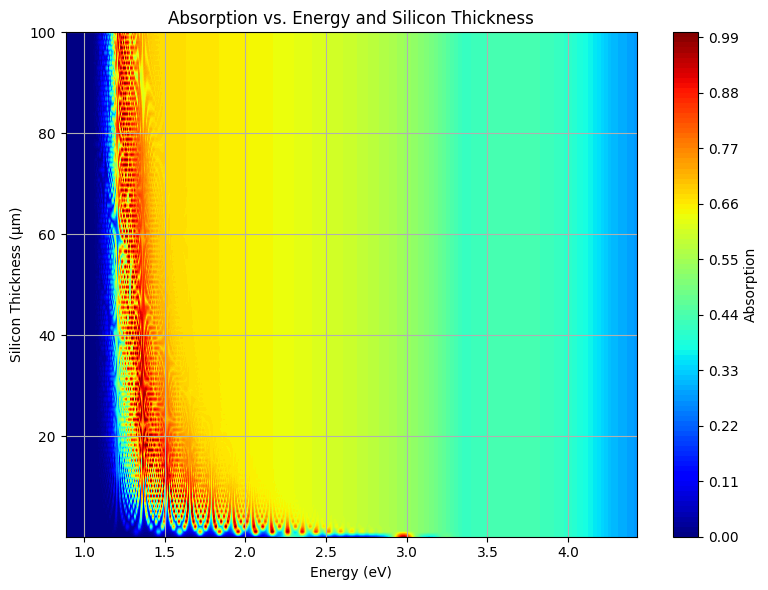

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

contour = ax.contourf(X, Y, absorption_results, levels=100, cmap='jet')

cbar = fig.colorbar(contour)
cbar.set_label("Absorption")

ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Silicon Thickness (µm)')
ax.set_title('Absorption vs. Energy and Silicon Thickness')
ax.grid()

plt.tight_layout()
plt.show()

## Ultrathin silicon example

There is interest in using ultrathin silicon for solar cells. Since silicon is an indirect band gap material, a number of approaches have been used to trap light in the silicon and increase absorption.  Here, we simulate the absorption of ultrathin silicon.  The leaky resonance modes in the crystalline silicon films can be observed.

[1] B. Wang, T. Gao, Z. Zhou, B. Pafchek, and P. W. Leu. [Frontside scattering structures for enhanced performance in flexible ultrathin crystalline silicon solar cells](https://doi.org/10.1117/1.JPE.8.030501). *Journal of Photonics for Energy*, vol. 8, no. 3, p. 030501, 2018.

[2] B. Wang, T. Gao, and P. W Leu. [Broadband light absorption enhancement in ultrathin film crystalline silicon solar cells with high index of refraction nanosphere arrays](https://doi.org/10.1016/j.nanoen.2015.10.039). *Nano Energy*, vol. 19, pp. 471–475, 2016.

[3] T. Gao, B. Wang, and P. W. Leu. [Plasmonic nanomesh sandwiches for ultrathin film silicon solar cells](https://doi.org/10.1088/2040-8986/19/2/025901). *Journal of Optics*, vol. 19, no. 2, p. 025901, 2016.

The total photons of the AM1.5 Global, denoted as `total_photons_solar`, were calculated in the previous cell.

In [12]:
wavelengths = jnp.linspace(280, 1200, 1000) * nano
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

silicon_thicknesses_in_nm = jnp.linspace(100.0, 1000.0, 100)
silicon_thicknesses = jll_utils_units.convert_nm_to_m(silicon_thicknesses_in_nm)

materials = ["Air", "cSi", "PEC"]
inc_angle = 0.0

irradiance = jll_utils_light_sources.get_irradiance('AM1p5G', wavelengths)
photon_flux = (irradiance * wavelengths) / (h * c)

n_k = jll_utils_materials.get_n_k(materials, frequencies)

absorption_spectra = []
solar_absorption_results = []

for thickness in silicon_thicknesses:
    thicknesses = jnp.array([0, thickness, 0])

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, inc_angle)
    A = 1 - R_TE - T_TE

    absorption_spectra.append(A)
    solar_absorption = onp.trapezoid(A * photon_flux, wavelengths / nano) / total_photons_solar
    solar_absorption_results.append(solar_absorption)

absorption_spectra = onp.array(absorption_spectra).squeeze()
solar_absorption_results = onp.array(solar_absorption_results).squeeze()

X, Y = onp.meshgrid(onp.array(jll_utils_units.convert_m_to_nm(wavelengths)), silicon_thicknesses_in_nm)

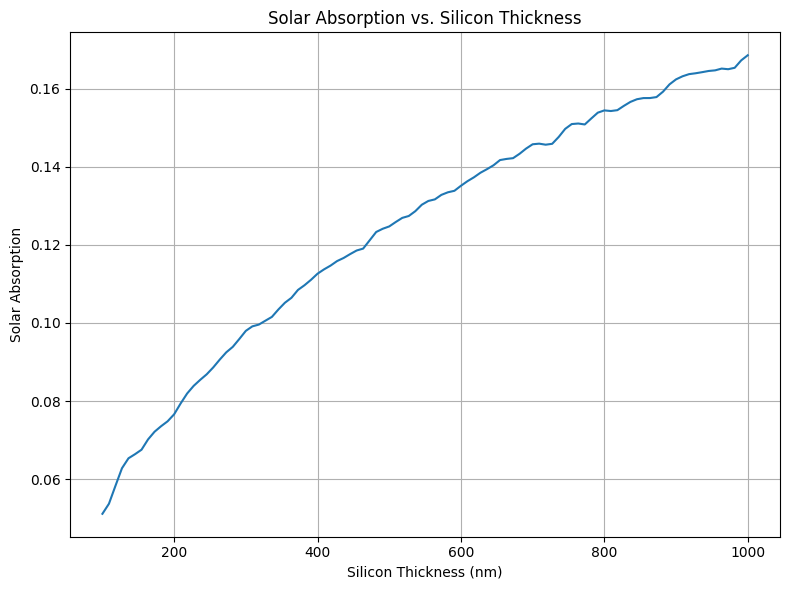

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(silicon_thicknesses_in_nm, solar_absorption_results)

ax.set_xlabel("Silicon Thickness (nm)")
ax.set_ylabel("Solar Absorption")
ax.set_title("Solar Absorption vs. Silicon Thickness")
ax.grid()

plt.tight_layout()
plt.show()

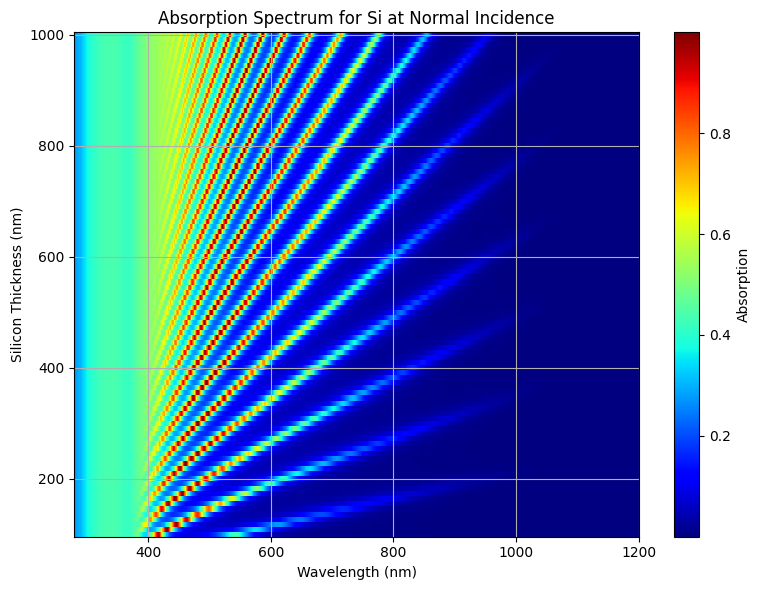

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

mesh = ax.pcolormesh(X, Y, absorption_spectra, cmap='jet')

cbar = fig.colorbar(mesh)
cbar.set_label("Absorption")

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Silicon Thickness (nm)")
ax.set_title("Absorption Spectrum for Si at Normal Incidence")
ax.grid()

plt.tight_layout()
plt.show()